In [1]:
from IPython.display import display, HTML
import os
import time
import pickle
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 300)
%matplotlib inline

def load_data(filename):
    with open(filename, 'rb') as fin:
        return pickle.load(fin)
    
def save_data(obj, filename):
    with open(filename, 'wb+') as fout:
        pickle.dump(obj, fout)
        
root_path = 'C:/Users/yuanl4/Documents/MelbDatathon2017/'

In [2]:
def read_patient(i):
    df = pd.read_csv(root_path + 'Final_summary/patient_%d.csv'%i)
    df.rename(columns={'Patient_ID':'PID', 'Store_ID':'SID', 'Drug_ID':'DID', 'Prescription_Week':'PresWeek',
                       'Dispense_Week':'DispWeek', 'PatientPrice_Amt':'PatientPrice', 
                       'WholeSalePrice_Amt':'WholeSalePrice', 'GovernmentReclaim_Amt':'GovernmentReclaim'},
              inplace=True)
    return df

In [3]:
%%time
transactions = []
for i in range(1, 51):
    print(i, end=' ')
    transactions.append(read_patient(i))
print('finish loading')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 finish loading
Wall time: 1min 3s


In [7]:
%%time
df = pd.concat(transactions, ignore_index=True)

Wall time: 1.97 s


In [9]:
drug_lookup = pd.read_csv('Lookups/Drug_LookUp_CN.csv', sep='\t', encoding='utf-16',
                          index_col='MasterProductID')

In [19]:
GovernmentReclaim_by_patient = np.bincount(df.PID.values, df.GovernmentReclaim.values)
PatientPrice_by_patient = np.bincount(df.PID.values, df.PatientPrice.values)

In [21]:
patient_summary = pd.DataFrame()
patient_summary['Patient_ID'] = np.arange(df.PID.max()) + 1
patient_summary['PatientPrice'] = PatientPrice_by_patient[1:]
patient_summary['GovernmentReclaim'] = GovernmentReclaim_by_patient[1:]

In [22]:
patient_summary.to_csv(root_path+'Summary/patient_price_reclaim_summary.csv', index=False)

In [18]:
for x in sorted(enumerate(reclaim_by_patient), key=lambda x:x[1], reverse=True)[:50]:
    print('%d\t%lf' % x)

512011	438401.010000
125102	364405.610000
136129	276894.700000
352924	263357.720000
479635	254360.640000
425863	244531.870000
351282	241549.190000
356084	230033.510000
163603	222372.100000
409199	222216.480000
120850	220059.380000
80763	218059.300000
198964	214752.920000
378317	214496.660000
82929	214055.180000
345284	211942.820000
190812	209373.260000
302303	207779.170000
193680	206653.230000
398056	206046.970000
236077	204052.460000
445374	203729.040000
40709	198442.780000
21143	191761.870000
66828	190331.400000
408892	187167.550000
190432	181561.910000
188704	181329.500000
148491	180938.830000
177170	180766.960000
131942	177506.700000
135621	176721.960000
5164	176343.270000
401039	175196.040000
417482	171641.750000
236583	169912.440000
176278	167980.170000
90353	167850.330000
272012	166898.550000
248963	166215.940000
509551	165719.840000
463695	164250.920000
367264	164061.930000
223872	163013.450000
315451	162560.940000
251601	160264.230000
26256	157663.400000
244763	155790.860000
7

In [119]:
df['Profit'] = df.PatientPrice + df.GovernmentReclaim - df.WholeSalePrice

In [176]:
df['Year'] = df.DispWeek.values.astype('datetime64[Y]').astype(int) + 1970

In [178]:
unique_year, encoded_year, count_year = np.unique(df.Year.values, return_inverse=True, return_counts=True)

In [124]:
unique_dispweek, encoded_dispweek, count_dispweek = np.unique(df.DispWeek.values, 
                                                              return_inverse=True, return_counts=True)

In [204]:
PatientPrice      = np.bincount(encoded_dispweek, df.PatientPrice.values)
GovernmentReclaim = np.bincount(encoded_dispweek, df.GovernmentReclaim.values)
WholeSalePrice    = np.bincount(encoded_dispweek, df.WholeSalePrice.values)
Profit            = np.bincount(encoded_dispweek, df.Profit.values)
plot = pd.DataFrame(index=unique_dispweek)
plot['PatientPrice'] = PatientPrice
plot['GovernmentReclaim'] = GovernmentReclaim
plot['WholeSalePrice'] = WholeSalePrice
plot['Profit'] = Profit
plot['Transactions'] = count_dispweek

In [213]:
PatientPrice      = np.bincount(encoded_year, df.PatientPrice.values)
GovernmentReclaim = np.bincount(encoded_year, df.GovernmentReclaim.values)
WholeSalePrice    = np.bincount(encoded_year, df.WholeSalePrice.values)
Profit            = np.bincount(encoded_year, df.Profit.values)
plot = pd.DataFrame(index=unique_year)
plot['PatientPrice'] = PatientPrice
plot['GovernmentReclaim'] = GovernmentReclaim
plot['WholeSalePrice'] = WholeSalePrice
plot['Profit'] = Profit
plot['Transactions'] = count_year

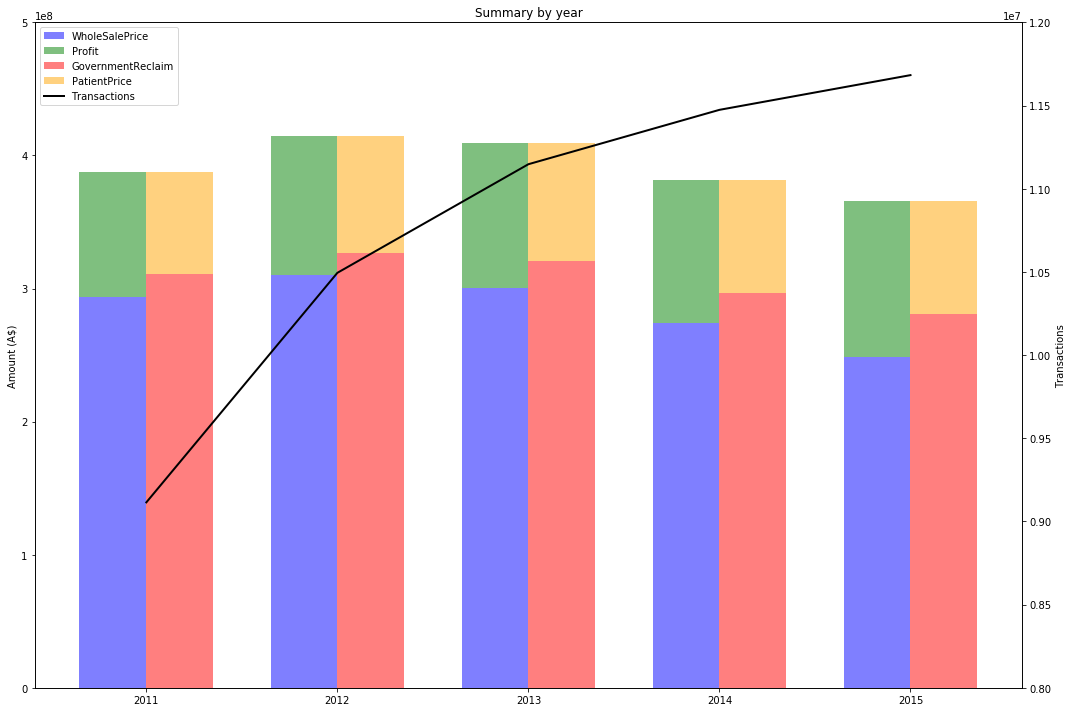

In [304]:
def plot_df(df):
    n_groups = df.shape[0]

    fig, ax1 = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.5

    rects1 = ax1.bar(index, df.WholeSalePrice, bar_width,
                     alpha=opacity, color='b',
                     label='WholeSalePrice')

    rects2 = ax1.bar(index, df.Profit, bar_width,
                     alpha=opacity, color='green', bottom=df.WholeSalePrice,
                     label='Profit')
    
    rects3 = ax1.bar(index + bar_width, df.GovernmentReclaim, bar_width,
                     alpha=opacity, color='r',
                     label='GovernmentReclaim')

    rects4 = ax1.bar(index + bar_width, df.PatientPrice, bar_width,
                     alpha=opacity, color='orange', bottom=df.GovernmentReclaim,
                     label='PatientPrice')

    ax1.set_ylabel('Amount (A$)')
    ax1.set_ylim(0, 5e8)
    
    ax2 = ax1.twinx()
    ax2.plot(index + bar_width / 2, df.Transactions, lw=2, color='black')
    ax2.set_ylabel('Transactions')
    ax2.set_ylim(0.8e7, 1.2e7)

    plt.xlabel('Year')
    plt.xticks(index + bar_width / 2, df.index)
    
    plt.title('Summary by year')
    # ask matplotlib for the plotted objects and their labels
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc=0)

    plt.tight_layout()
    plt.show()
    
    fig.savefig('test.png', bbox_inches='tight')
plot_df(plot.loc[2011:2015])

In [261]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

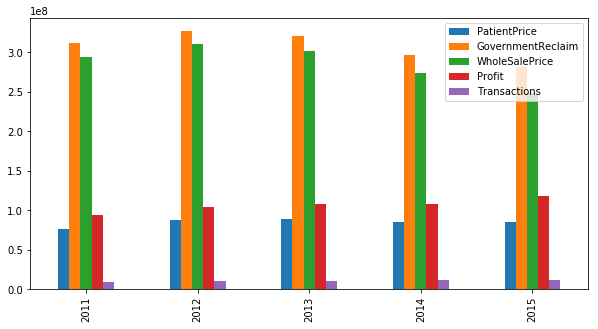

In [249]:
plot.loc[2011:2015].plot(kind='bar')

In [305]:
unique_SID, encoded_SID, count_SID = np.unique(df.SID.values, return_inverse=True, return_counts=True)

In [307]:
profit_by_SID = np.bincount(encoded_SID, df.Profit)

In [314]:
for i in np.argsort(profit_by_SID)[-10:]:
    print('%d\t%lf\t%d' % (unique_SID[i], profit_by_SID[i], count_SID[i]))

2503	1255486.110000	134545
1077	1266160.650000	122727
1461	1319658.680000	135290
2475	1325104.050000	131056
2087	1358334.600000	131376
806	1383110.790000	136437
1005	1483888.740000	157201
253	2705200.599999	282751
2227	2841368.929999	295823
-9999	7600821.550002	387119


In [315]:
unique_SID[profit_by_SID<0]

array([ 907,  953, 1117, 1369, 1438, 1583, 1775, 2117, 2141, 2145, 2332], dtype=int64)

In [326]:
store_summary = pd.DataFrame(columns=['StoreID', 'Transactions', 'Profit'])
store_summary['StoreID'] = unique_SID
store_summary['Transactions'] = count_SID
store_summary['Profit'] = profit_by_SID
store_summary.set_index('StoreID', inplace=True)
display(store_summary)
store_summary.to_csv('store_summary.csv')

,Transactions,Profit
StoreID,,
-9999,387119,7.600822e+06
1,18617,1.902225e+05
2,28995,3.016723e+05
3,5,6.304000e+01
4,91082,8.721634e+05
5,66227,6.262899e+05
7,63213,5.924364e+05
8,31883,3.201722e+05
9,2984,2.786907e+04


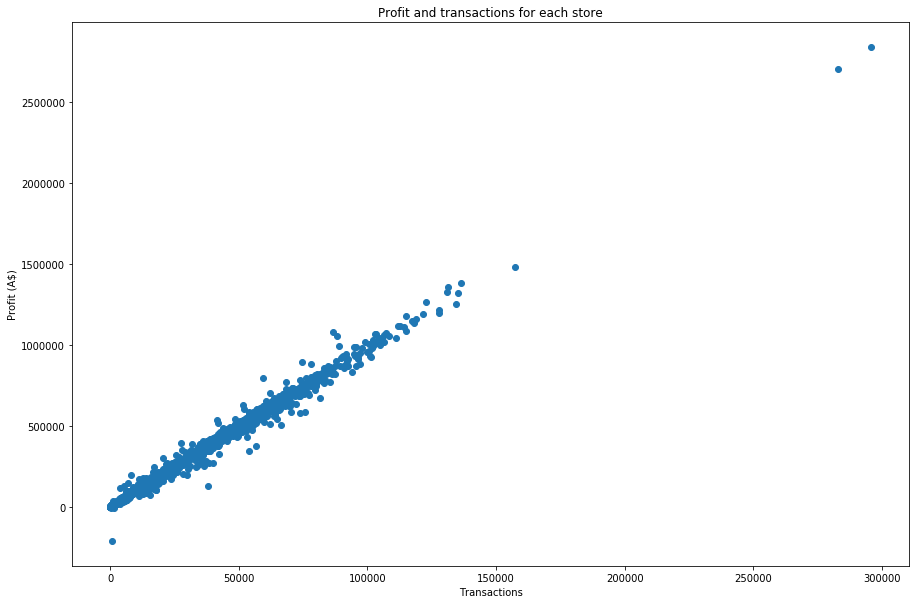

In [329]:
# skip the first one, as it is -9999
fig, ax = plt.subplots()
ax.scatter(count_SID[1:], profit_by_SID[1:])
ax.set_xlabel('Transactions')
ax.set_ylabel('Profit (A$)')
ax.set_title('Profit and transactions for each store')
fig.savefig('Profit and transactions for each store.png', bbox_inches='tight')

In [292]:
unique_PID, encoded_PID, count_PID = np.unique(df.PID.values, return_inverse=True, return_counts=True)

In [294]:
unique_PID[np.argmax(count_PID)]

90353

In [295]:
PID_set_by_year = {}
for year in range(2008, 2018):
    PID_set_by_year[year] = set(np.unique(df.PID.values[df.Year==year]))

In [303]:
print('year\t PID\t new')
for year in range(2009, 2018):
    print('%d\t %d\t %d' % (year, len(PID_set_by_year[year]), len(PID_set_by_year[year] - PID_set_by_year[year-1])))

year	 PID	 new
2009	 1	 0
2010	 941	 941
2011	 537660	 536748
2012	 532282	 14608
2013	 530185	 10573
2014	 529292	 11103
2015	 529606	 12871
2016	 273367	 10739
2017	 217069	 2603


In [76]:
np.argmax(df.WholeSalePrice.values)

11264092

In [77]:
df.loc[11264092]

PID                        93683
SID                          829
DID                        11212
PresWeek              2015-02-15
DispWeek              2015-05-31
PatientPrice                   0
WholeSalePrice       1.04187e+06
GovernmentReclaim        2637.69
Profit              -1.03924e+06
Name: 11264092, dtype: object

In [78]:
df.loc[df.PID==93683]

,PID,SID,DID,PresWeek,DispWeek,PatientPrice,WholeSalePrice,GovernmentReclaim,Profit
11263995,93683,2713,2056,2011-04-10,2011-05-08,5.60,62.23,69.27,12.64
11263996,93683,2713,2119,2011-02-13,2011-05-08,5.60,101.88,112.89,16.61
11263997,93683,2713,2119,2011-02-13,2011-06-05,5.60,101.88,112.89,16.61
11263998,93683,2713,2056,2011-04-10,2011-06-05,5.60,62.23,69.27,12.64
11263999,93683,2713,9337,2011-04-10,2011-07-10,7.60,13.76,14.67,8.51
11264000,93683,2713,9337,2011-04-10,2011-07-10,7.60,13.76,14.67,8.51
11264001,93683,2713,2786,2011-04-10,2011-07-10,5.60,62.23,69.27,12.64
11264002,93683,2713,9337,2011-04-10,2011-08-07,7.60,13.76,14.67,8.51
11264003,93683,2713,1160,2011-04-10,2011-08-28,8.70,6.34,5.02,7.38
11264004,93683,2713,2119,2011-08-14,2011-10-02,5.60,101.88,112.89,16.61
